In [2]:
'''
This code will grab USGS streamflow data for a defined period of interest 

'''

# first import the functions for downloading data from NWIS
import dataretrieval.nwis as nwis
import pandas as pd
import matplotlib.pyplot as plt

# specify the USGS site code for which we want data.
site = ['01054500']

# get instantaneous values (iv)
df = nwis.get_record(sites=site, service='iv', start='2019-06-01', end='2019-10-01')
df.reset_index(inplace=True) #reset index to grab station date
df['datetime'] = pd.to_datetime(df['datetime'], utc=True, format = '%Y-%m-%d %H:%M:%S') #transfer to utc so same time throughout
df_quarter = df.iloc[:,[0,4]] #locates every row by the columns we want (date and flow)
df_quarter.columns = ['Date', 'Flow'] # rename column headers 
print(df_quarter)

## Make copy od dataframe to average flow every hour 
df_copy = df.copy()
df_copy['datetime'] = pd.to_datetime(df_copy['datetime'], utc=True, format = '%Y-%m-%d %H:%M:%S') #convert datetime to average every hour 
#df_copy.reset_index(inplace=True) #reset indexes so can grab "Date" column
#df_copy.drop("datetime", axis=1, inplace=True) #drop unneccsary date column now 
df_copy.index = df_copy['datetime'] # index so can pull date time in resample
df_avg = df_copy.resample('H').mean() # Average every hour based on datetime
df_avg.reset_index(inplace=True) #reset index again to have datetime 
df_avgflow = df_avg.iloc[:,[0,2]] #locates every row by the columns we want (date and flow)
df_avgflow.columns = ['Date', 'Flow']
print(df_avgflow)


                           Date  Flow
0     2019-06-01 04:00:00+00:00  5.21
1     2019-06-01 04:15:00+00:00  5.20
2     2019-06-01 04:30:00+00:00  5.20
3     2019-06-01 04:45:00+00:00  5.18
4     2019-06-01 05:00:00+00:00  5.19
...                         ...   ...
11803 2019-10-02 02:45:00+00:00  3.50
11804 2019-10-02 03:00:00+00:00  3.50
11805 2019-10-02 03:15:00+00:00  3.50
11806 2019-10-02 03:30:00+00:00  3.50
11807 2019-10-02 03:45:00+00:00  3.51

[11808 rows x 2 columns]
                          Date    Flow
0    2019-06-01 04:00:00+00:00  5.1975
1    2019-06-01 05:00:00+00:00  5.1825
2    2019-06-01 06:00:00+00:00  5.1625
3    2019-06-01 07:00:00+00:00  5.1575
4    2019-06-01 08:00:00+00:00  5.1500
...                        ...     ...
2947 2019-10-01 23:00:00+00:00  3.5300
2948 2019-10-02 00:00:00+00:00  3.5275
2949 2019-10-02 01:00:00+00:00  3.4950
2950 2019-10-02 02:00:00+00:00  3.5000
2951 2019-10-02 03:00:00+00:00  3.5025

[2952 rows x 2 columns]


In [3]:
## Make new list of standard error associated with each flow measurement in 15min USGS data
df_error = df_quarter.loc[:,"Flow"]

#calculate minimum error of flow
df_error_min_plus = (df_error*0.02) + df_error
df_error_min_minus = (df_error*0.02*-1) + df_error
#calculate maximum error of flow
df_error_max_plus = (df_error*0.2) + df_error
df_error_max_minus = (df_error*0.2*-1) + df_error

#concatonate error columns together
df_error_table = pd.concat([df_error_min_plus, df_error_min_minus, df_error_max_plus, df_error_max_minus],axis=1)
df_error_table.columns = ['Min_Error_Plus','Min_Error_Minus', 'Max_Error_Plus', 'Max_Error_Minus']
#print(df_error_table)

#concatonate 15min USGS data with error bars
df_final = pd.concat([df_quarter, df_error_table], axis=1)
print(df_final)


                           Date  Flow  Min_Error_Plus  Min_Error_Minus  \
0     2019-06-01 04:00:00+00:00  5.21          5.3142           5.1058   
1     2019-06-01 04:15:00+00:00  5.20          5.3040           5.0960   
2     2019-06-01 04:30:00+00:00  5.20          5.3040           5.0960   
3     2019-06-01 04:45:00+00:00  5.18          5.2836           5.0764   
4     2019-06-01 05:00:00+00:00  5.19          5.2938           5.0862   
...                         ...   ...             ...              ...   
11803 2019-10-02 02:45:00+00:00  3.50          3.5700           3.4300   
11804 2019-10-02 03:00:00+00:00  3.50          3.5700           3.4300   
11805 2019-10-02 03:15:00+00:00  3.50          3.5700           3.4300   
11806 2019-10-02 03:30:00+00:00  3.50          3.5700           3.4300   
11807 2019-10-02 03:45:00+00:00  3.51          3.5802           3.4398   

       Max_Error_Plus  Max_Error_Minus  
0               6.252            4.168  
1               6.240        

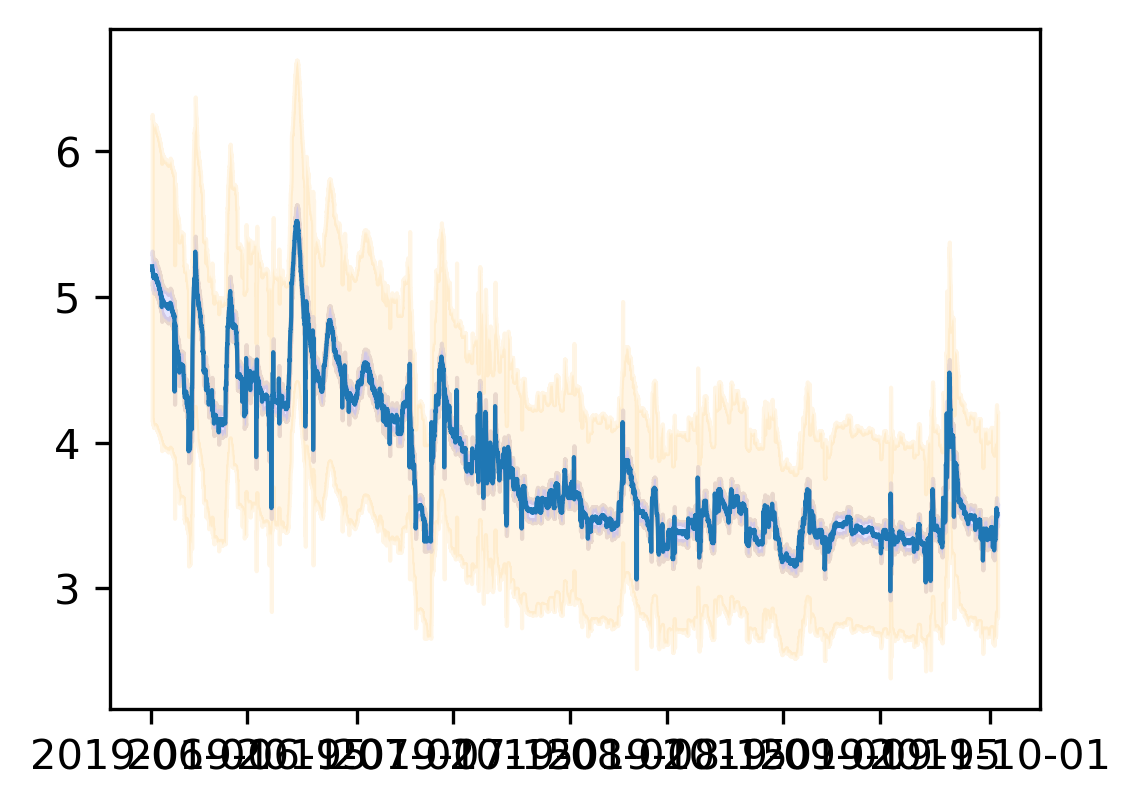

In [5]:
## Visualize the error bars with USGS data
flow = df_final.loc[:,"Flow"]
y = df_final.loc[:,"Min_Error_Plus"]
y2 =  df_final.loc[:,"Min_Error_Minus"]
y3 = df_final.loc[:,"Max_Error_Plus"]
y4 =  df_final.loc[:,"Max_Error_Minus"]
x = df_final.loc[:,"Date"]

## Start plotting
fig = plt.figure(figsize = (4,3), dpi=300)
#fig, ax = plt.subplots()
plt.plot(x, flow,linewidth=1)
#plt.plot(x, y, color = 'tab:red',linewidth=0.1)
#plt.plot(x, y2, color = 'tab:red',linewidth=0.1)
#plt.plot(x, y3, color = 'tab:green',linewidth=0.1)
#plt.plot(x, y4, color = 'tab:green',linewidth=0.1)
plt.fill_between(x, flow, y, color='blue', alpha=.2)
plt.fill_between(x, flow, y2, color='blue', alpha=.2)
plt.fill_between(x, y, y3, color='orange', alpha=.2)
plt.fill_between(x, y2, y4, color='orange', alpha=.2)
#plt.title(output)
plt.show()
